#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [2]:
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime
import pytz
import csv
import os
import matplotlib.pyplot as plt

%matplotlib inline

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)


def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

#### Read data

In [3]:
DATA_FOLDER = './'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
date_df = pd.read_pickle("russian_holidays.pkl")
geography = pd.read_csv('geography.csv')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
holiday_filepath = 'hol.feather'
holidays = feather.read_dataframe(holiday_filepath)


(2935849, 6)
(214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100


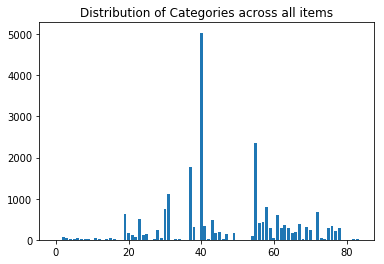

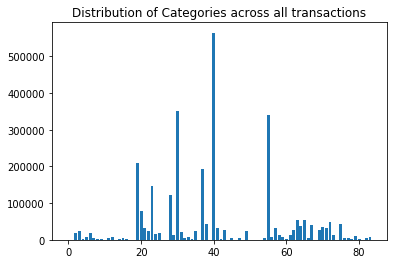

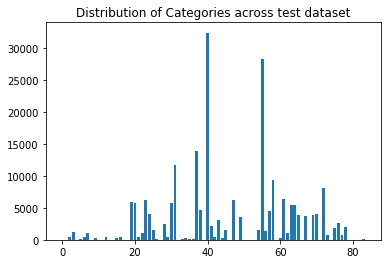




# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




In [4]:
print(sales.shape)
print(test.shape)
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

unique_categories, count = np.unique(items.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories, count)    
plt.title( "Distribution of Categories across all items")
plt.show()

unique_categories_trans, count_trans = np.unique(transactions.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_trans, count_trans)
plt.title("Distribution of Categories across all transactions")
plt.show()

test_mod = pd.merge(test, items[['item_id', 'item_category_id']], on='item_id', how='left')
unique_categories_test, count_test = np.unique(test_mod.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_test, count_test)
plt.title("Distribution of Categories across test dataset")
plt.show()

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")

###### Constructing previous_value_benchmark

For the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

In [ ]:
# def get_item_cnt(shopid, itemid):
#     if (shopid, itemid) in trans_oct_grouped:
#         count  = trans_oct_grouped[int(shopid), int(itemid)]
#         if(count > 20):
#             return 20
#         elif(count < 0):
#             return 0
#         else:
#             return count
#     else:
#         return 0

# trans_oct = transactions[transactions.date_block_num == 33]
# trans_oct_grouped = trans_oct.groupby(["shop_id", "item_id"]).item_cnt_day.sum()
# previous_value_benchmark_submission = test

# previous_value_benchmark_submission["item_cnt_month"] = previous_value_benchmark_submission.apply(lambda x: get_item_cnt(x.shop_id, x.item_id), axis=1)
# print(previous_value_benchmark_submission.item_cnt_month.describe())

# # writing previous_value_benchmark_submission ---> csv file
# previous_value_benchmark_submission[["ID", "item_cnt_month"]].to_csv("previous_value_benchmark_submission", index=False)

##### Building the shops data frame

In [5]:
# Setting the shop_type
shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК']
shops["shop_type"] = shops.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')

# Setting the city for each shop
shops["city"] = shops.shop_name.apply(lambda x: x.split()[0].replace("!", ""))

# Appending the geographic info to shops df
shops = pd.merge(shops, geography.drop(['city_eng'], axis=1), on='city', how='inner')

print(shops.shape)
shops.head()

(60, 8)


,shop_name,shop_id,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,"!Якутск Орджоникидзе, 56 фран",0,OTH,Якутск,9,Sakha Republic,Far East,8395
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,Якутск,9,Sakha Republic,Far East,8395
2,"Якутск Орджоникидзе, 56",57,OTH,Якутск,9,Sakha Republic,Far East,8395
3,"Якутск ТЦ ""Центральный""",58,ТЦ,Якутск,9,Sakha Republic,Far East,8395
4,"Адыгея ТЦ ""Мега""",2,ТЦ,Адыгея,3,Adygea Republic,South,1589


In [6]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [8]:
moscow = timezone('Europe/Moscow')

#### Build the initial training df

In [9]:
# Group the data by [date, shop_id, item_id] to find the cumulative count on a day for shop-item pair. 
# Price is ignored for now
# transactions = pd.merge(sales, items[['item_id', 'item_category_id']], on='item_id', how='left')

train_df = sales.groupby(['date', 'date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index(name='item_cnt')
train_df.drop('date_block_num', axis=1, inplace=True)

def get_datetime(s):    
    a = s.split(".")
    y,m,d = int(a[2]), int(a[1]), int(a[0])
    return datetime.datetime(y,m,d, tzinfo = moscow)

train_df['date'] = train_df['date'].apply(get_datetime)

In [10]:
print(min(train_df.date))
print(max(train_df.date))

2013-01-01 01:30:00+04:00
2015-10-31 00:30:00+03:00


In [11]:
train_df.head()

,date,shop_id,item_id,item_cnt
0,2013-01-01 01:30:00+04:00,2,991,1.0
1,2013-01-01 01:30:00+04:00,2,1472,1.0
2,2013-01-01 01:30:00+04:00,2,1905,1.0
3,2013-01-01 01:30:00+04:00,2,2920,2.0
4,2013-01-01 01:30:00+04:00,2,3320,1.0


##### looking at the price variability  (we may have to include price as a feature later on! ... we will see)

In [607]:
# # looking at the price variability (in training data) of items which are in the test set.

# trans_sub = transactions[transactions.item_id.isin(test.item_id.unique())]
# print("total unique items in test set: {}".format(len(test.item_id.unique())))

# num_const_price_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 1)
# print(num_const_price_items)

# price_change1_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 2)
# print(price_change1_items)

# price_change2_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 3)
# print(price_change2_items)

# price_change3_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 4)
# print(price_change3_items)

# price_change4_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 5)
# print(price_change4_items)

# price_change5_items = sum(trans_sub.groupby('item_id').item_price.nunique() == 6)
# print(price_change5_items)

# print("\n")

# print(num_const_price_items + price_change1_items + price_change2_items +
#       price_change3_items + price_change4_items + price_change5_items)

#### Set-up the initial test df

In [12]:
from itertools import product

# Test set is for November, 2015
year=2015
month=11

# get the list of dates in Nov-2015
date_list = get_dates_in_month(year, month, moscow)

index_cols = ['shop_id', 'item_id', 'date']

# grid will have all cominates of shop_ids, item_ids and dates (shape: 6426000 rows, 3 columns)
grid = []
test_items = test.item_id.unique()
test_shops = test.shop_id.unique()
for d in date_list:
    grid.append(np.array(list(product(*[test_shops, test_items, [d]]))))

# Turn the grid into a dataframe
index_cols = ['shop_id', 'item_id', 'date']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols)

test_df = grid

test_df.head()

,shop_id,item_id,date
0,5,5037,2015-11-01 00:00:00+02:30
1,5,5320,2015-11-01 00:00:00+02:30
2,5,5233,2015-11-01 00:00:00+02:30
3,5,5232,2015-11-01 00:00:00+02:30
4,5,5268,2015-11-01 00:00:00+02:30


#### Modify train and test set simultaneously using same functions

In [13]:
# weekdays [monday-1, 2, .... 7-sunday]
test_df['weekday']  = test_df['date'].apply(lambda x: x.isoweekday())
train_df['weekday'] = train_df['date'].apply(lambda x: x.isoweekday())

train_df['is_weekend'] = train_df['weekday'] > 5
test_df['is_weekend'] = test_df['weekday'] > 5

# Generating a date-string
test_df['date_str']  = test_df.date.apply(lambda x: x.isoformat().split("T")[0])
train_df['date_str'] = train_df.date.apply(lambda x: x.isoformat().split("T")[0])

# Appending category_id
test_df = pd.merge(test_df, items[['item_id', 'item_category_id']], on='item_id', how='left')
train_df = pd.merge(train_df, items[['item_id', 'item_category_id']], on='item_id', how='left')

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

# Appending isholiday
test_df = pd.merge(test_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
test_df['is_holiday'].fillna(False, inplace=True)
train_df = pd.merge(train_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
train_df['is_holiday'].fillna(False, inplace=True)

# off_days - sunday, saturday, holidays-off_days
test_df = pd.merge(test_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
test_df.loc[test_df.loc[:, 'weekday'] > 5, 'off_day'] = True
train_df = pd.merge(train_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
train_df.loc[train_df.loc[:, 'weekday'] > 5, 'off_day'] = True

# Appending shop information
test_df = pd.merge(test_df, shops, on='shop_id', how='left')
train_df = pd.merge(train_df, shops, on='shop_id', how='left')

In [14]:
print(train_df.shape)
train_df.head()

(2945121, 17)


,date,shop_id,item_id,item_cnt,weekday,is_weekend,date_str,item_category_id,is_holiday,off_day,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,2013-01-01 01:30:00+04:00,2,991,1.0,2,False,2013-01-01,67,True,True,"Адыгея ТЦ ""Мега""",ТЦ,Адыгея,3,Adygea Republic,South,1589
1,2013-01-01 01:30:00+04:00,2,1472,1.0,2,False,2013-01-01,23,True,True,"Адыгея ТЦ ""Мега""",ТЦ,Адыгея,3,Adygea Republic,South,1589
2,2013-01-01 01:30:00+04:00,2,1905,1.0,2,False,2013-01-01,30,True,True,"Адыгея ТЦ ""Мега""",ТЦ,Адыгея,3,Adygea Republic,South,1589
3,2013-01-01 01:30:00+04:00,2,2920,2.0,2,False,2013-01-01,21,True,True,"Адыгея ТЦ ""Мега""",ТЦ,Адыгея,3,Adygea Republic,South,1589
4,2013-01-01 01:30:00+04:00,2,3320,1.0,2,False,2013-01-01,19,True,True,"Адыгея ТЦ ""Мега""",ТЦ,Адыгея,3,Adygea Republic,South,1589


In [15]:
print(test_df.shape)
test_df.head()

(6426000, 16)


,shop_id,item_id,date,weekday,is_weekend,date_str,item_category_id,is_holiday,off_day,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,5,5037,2015-11-01 00:00:00+02:30,7,True,2015-11-01,19,False,True,"Вологда ТРЦ ""Мармелад""",ТРЦ,Вологда,3,Vologda Oblast,Northwest,466
1,5,5320,2015-11-01 00:00:00+02:30,7,True,2015-11-01,55,False,True,"Вологда ТРЦ ""Мармелад""",ТРЦ,Вологда,3,Vologda Oblast,Northwest,466
2,5,5233,2015-11-01 00:00:00+02:30,7,True,2015-11-01,19,False,True,"Вологда ТРЦ ""Мармелад""",ТРЦ,Вологда,3,Vologda Oblast,Northwest,466
3,5,5232,2015-11-01 00:00:00+02:30,7,True,2015-11-01,23,False,True,"Вологда ТРЦ ""Мармелад""",ТРЦ,Вологда,3,Vologda Oblast,Northwest,466
4,5,5268,2015-11-01 00:00:00+02:30,7,True,2015-11-01,20,False,True,"Вологда ТРЦ ""Мармелад""",ТРЦ,Вологда,3,Vologda Oblast,Northwest,466


In [16]:
# Augmenting the training set so that we have one unique entry for every [date, shop and item]
# total_days(~ 990) * total unique items in training(21807) * total shops(60)

train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,10,31, tzinfo=moscow)
date_list = get_dates_inrange(train_first_date, train_last_date)

index_cols = ['shop_id', 'item_id', 'date']

# grid will have all cominates of shop_ids, item_ids and dates (shape: 6426000 rows, 3 columns)
grid = []
all_items = items.item_id.unique()
all_shops = shops.shop_id.unique()
for d in date_list:
    grid.append(np.array(list(product(*[all_shops, all_items, [d]]))))

# Turn the grid into a dataframe
index_cols = ['shop_id', 'item_id', 'date']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols)

train_mod = grid

MemoryError: 